## 1 REINFORCE算法

REINFORC算法实施流程如下

![image.png](https://s2.loli.net/2024/02/03/Fg4uAnixtTfvJ3j.png)

首先，我们需要初始化CartPole-v1环境和Agent

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# 初始化环境
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n


# 定义策略网络
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)


# 初始化策略网络和优化器
policy_network = PolicyNetwork()
optimizer = optim.Adam(policy_network.parameters(), lr=0.01)

c:\Users\shuai\miniconda3\envs\rllm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2 定义损失函数

$$\mathcal{L}(\theta) = -\mathbb{E} \left[ \sum_{t=1}^{T} \log \pi_{\theta}(a_t|s_t) \cdot G_t \right]$$

- $T$：表示一个episode中的时间步总数
- $t$：表示时间步
- $R_t$：表示在时间步$t$获得的回报
- $\pi_{\theta}(a_t|s_t)$：表示在状态$s_t$下，根据策略$\pi$选择动作$a_t$的概率
- $G_t$：表示从时间步$t$开始的总回报，即$G_t = R_t + \gamma R_{t+1} + \ldots + \gamma^{T-t}R_T$

这里，$\mathbb{E}$表示对所有可能的状态-动作轨迹进行期望。损失函数的含义是最大化预期回报，即使得代理根据策略$\pi_{\theta}$选择的动作能够使得预期回报最大化。

损失函数的目标是通过最大化预期回报来更新策略参数$\theta$，使得智能体在与环境的交互中获得更高的累积奖励。



In [2]:
def compute_loss(rewards, log_probs):
    returns = []
    discounted_reward = 0
    for r in rewards[::-1]:
        discounted_reward = r + 0.99 * discounted_reward
        returns.insert(0, discounted_reward)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    loss = []
    for log_prob, R in zip(log_probs, returns):
        loss.append(-log_prob * R)
    return torch.cat(loss).sum()

## 3 REINFORCE算法


In [3]:
def train(episodes):
    episode_rewards = []  # 存储每个episode的总奖励值
    for episode in range(episodes):
        state = env.reset()
        log_probs = []
        rewards = []
        total_reward = 0  # 记录每个episode的总奖励值
        while True:
            if type(state) == tuple:
                state = state[0]
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            action_probs = policy_network(state_tensor)
            m = Categorical(action_probs)
            action = m.sample()
            log_probs.append(m.log_prob(action))
            next_state, reward, done, terminal, *info = env.step(
                action.item()
            )  # 解包返回的元组
            rewards.append(reward)
            total_reward += reward  # 累加每个时间步的奖励值
            if done:
                break
            state = next_state  # 更新状态

        episode_rewards.append(total_reward)  # 将每个episode的总奖励值添加到列表中

        optimizer.zero_grad()
        loss = compute_loss(rewards, log_probs)
        loss.backward()
        optimizer.step()

        if episode % 10 == 0:
            print(f"Episode {episode}, loss: {loss.item()}")
    return episode_rewards

## 3 训练

模型训练并绘制每条轨迹的奖励值变化曲线

Episode 0, loss: 0.002564966445788741
Episode 10, loss: 0.0024596916045993567
Episode 20, loss: 0.0022536455653607845
Episode 30, loss: 0.00226198835298419
Episode 40, loss: 0.0023443824611604214
Episode 50, loss: 0.0021499732974916697
Episode 60, loss: 0.0015107265207916498
Episode 70, loss: 0.0020162826403975487
Episode 80, loss: 0.001667942851781845
Episode 90, loss: 0.0016748523339629173
Episode 100, loss: 0.001436069025658071
Episode 110, loss: 0.0018164915964007378
Episode 120, loss: 0.0009867942426353693
Episode 130, loss: 0.0012418668484315276
Episode 140, loss: 0.0011849816655740142
Episode 150, loss: 0.001227870350703597
Episode 160, loss: 0.0012358534149825573
Episode 170, loss: 0.0013076217146590352
Episode 180, loss: 0.0008294307626783848
Episode 190, loss: 0.0009490673546679318
Episode 200, loss: 0.0010305432369932532
Episode 210, loss: 0.0008409921429120004
Episode 220, loss: 0.0009490908705629408
Episode 230, loss: 0.0009271720773540437
Episode 240, loss: 0.000759057293

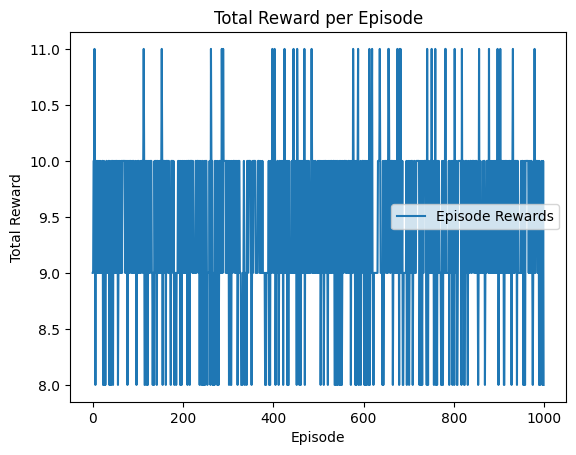

In [6]:
import matplotlib.pyplot as plt

# 训练代理
episode_rewards = train(1000)

# 检查episode_rewards是否包含有效数值
if episode_rewards:
    # 绘制奖励变化图表
    plt.plot(episode_rewards, label="Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward per Episode")
    plt.legend()
    plt.show()
else:
    print("No episode rewards data to plot.")
